<a href="https://colab.research.google.com/github/bilychka-v/3a-lab-OOOP/blob/main/lab4/lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Введіть степінь інтерполяційного полінома: 1

Для рівномірних вузлів:

Таблиця розділених різниць:
------------------------------------
              x            f(x)      f[x0...x1]
------------------------------------
       2.000000       1.000000       0.000000
       4.000000       1.000000
------------------------------------
Метод Лагранжа (рівномірні вузли): 0.024336 сек
Метод Лагранжа: 0.016210 сек
Метод Ньютона: 0.004118 сек


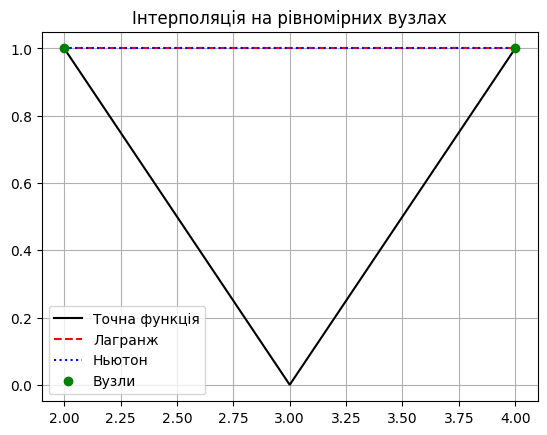

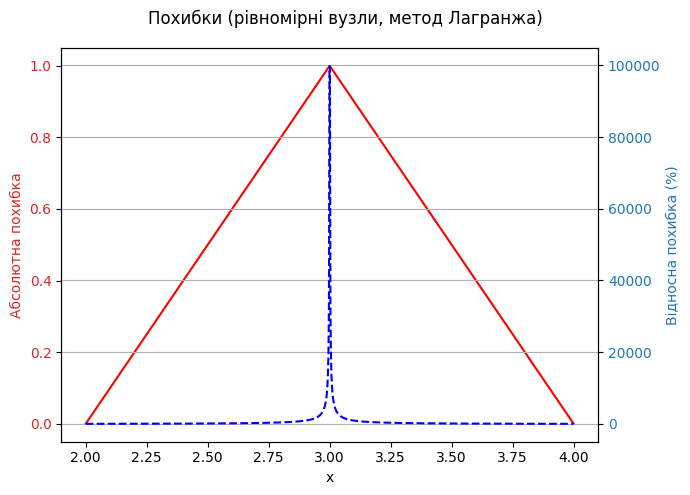

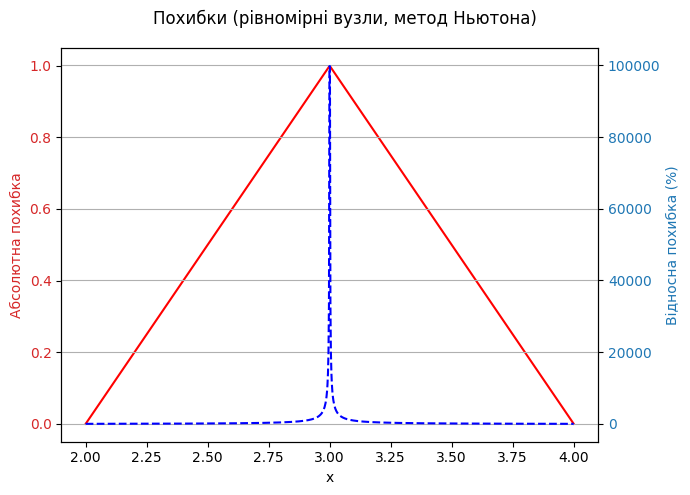


Для вузлів Чебишова:

Таблиця розділених різниць:
------------------------------------
              x            f(x)      f[x0...x1]
------------------------------------
       3.707107       0.707107      -0.000000
       2.292893       0.707107
------------------------------------
Метод Лагранжа (вузли Чебишова): 0.029001 сек
Метод Ньютона (вузли Чебишова): 0.004132 сек
Метод Лагранжа: 0.014788 сек
Метод Ньютона: 0.004049 сек


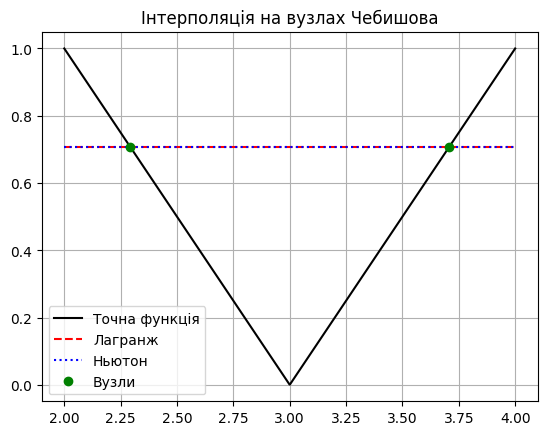

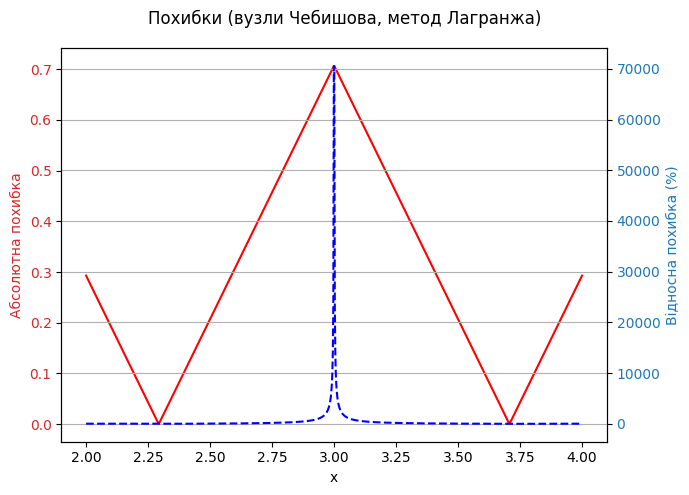

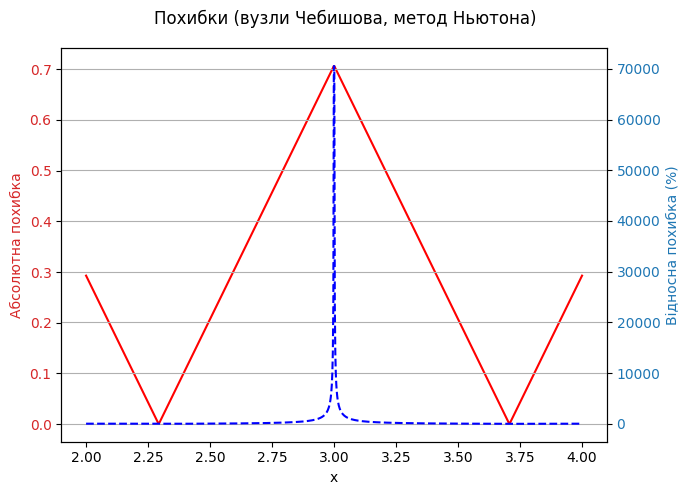

In [4]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from time import time

# Функція та її похідна
def f(x):
    """Функція f(x) = |x - 3|"""
    return np.abs(x - 3)

def df(x):
    """Похідна функції f(x) = |x - 3|"""
    return np.where(x > 3, 1, -1)  # Невизначена у точці x = 3, але визначаємо на основі сторін

# Знаходження монотонності функції
def find_monotonicity(df, a, b, steps=1000):
    x_values = np.linspace(a, b, steps)  # Генеруємо точки для аналізу
    derivative = df(x_values)  # Обчислюємо значення похідної

    increasing = np.all(derivative >= 0)  # Перевірка на зростання
    decreasing = np.all(derivative <= 0)  # Перевірка на спадання

    if increasing:
        return "монотонно зростаюча", [(a, b)]
    elif decreasing:
        return "монотонно спадна", [(a, b)]

    intervals = []
    start = a

    for i in range(1, len(x_values)):
        if np.sign(derivative[i-1]) != np.sign(derivative[i]):
            end = (x_values[i-1] + x_values[i]) / 2
            intervals.append((start, end))
            start = end

    intervals.append((start, b))
    return "немонотонна", intervals

# Вузли Чебишова для інтерполяції
def chebyshev_nodes(a, b, n):
    """Генерує вузли Чебишова для інтерполяції"""
    i = np.arange(n)
    nodes = ((a + b) + (b - a) * np.cos((2 * i + 1) * np.pi / (2 * n))) / 2  # Формула вузлів Чебишова
    return nodes

# Рівномірні вузли для інтерполяції
def uniform_nodes(a, b, n):
    """Генерує рівномірно розподілені вузли"""
    return np.linspace(a, b, n)

# Інтерполяція Лагранжа
def lagrange_interpolation(x, nodes, values):
    """Інтерполяція функції за допомогою полінома Лагранжа"""
    n = len(nodes)
    if n != len(values):
        raise ValueError("Кількість вузлів і значень повинна збігатися.")

    result = 0.0  # Початкове значення результату

    for i in range(n):
        # Обчислення базисного полінома Лагранжа
        term = values[i] * np.prod([(x - nodes[j]) / (nodes[i] - nodes[j]) for j in range(n) if i != j])
        result += term

    return result

# Функція для обчислення розділених різниць Ньютона
def divided_differences(x, y):
    """Розрахунок таблиці розділених різниць"""
    n = len(y)
    coef = np.zeros([n, n])
    coef[:, 0] = y  # Початковий стовпець — значення функції у вузлах

    for j in range(1, n):
        for i in range(n - j):
            coef[i][j] = (coef[i + 1][j - 1] - coef[i][j - 1]) / (x[i + j] - x[i])  # Розділені різниці

    return coef[0, :], coef  # Повертає коефіцієнти та повну таблицю

# Інтерполяція Ньютона
def newton_interpolation(x_val, x_nodes, y_nodes):
    """Інтерполяція за методом Ньютона"""
    n = len(x_nodes)
    coefficients, _ = divided_differences(x_nodes, y_nodes)

    result = coefficients[0]  # Початкове значення полінома
    product_term = 1.0  # Початковий множник

    for i in range(1, n):
        product_term *= (x_val - x_nodes[i - 1])  # Формуємо добуток (x - x0)(x - x1)...
        result += coefficients[i] * product_term

    return result



def calculate_absolute_error(y_exact, y_interpolated):
    """
    Обчислює абсолютну похибку між точними та інтерпольованими значеннями.
    """
    return np.abs(np.array(y_exact) - np.array(y_interpolated))  # Обчислюємо абсолютну різницю між масивами


def calculate_relative_error(y_exact, y_interpolated):
    """
    Обчислює відносну похибку між точними та інтерпольованими значеннями.
    """
    absolute_error = calculate_absolute_error(y_exact, y_interpolated)  # Обчислюємо абсолютну похибку
    return (absolute_error / (np.array(y_exact) + 1e-10)) * 100  # Обчислюємо відносну похибку та переводимо у відсотки


def calculate_errors(x_plot, y_exact, y_interpolated):
    """
    Обчислює як абсолютну, так і відносну похибки для інтерполяції.
    """
    absolute_error = calculate_absolute_error(y_exact, y_interpolated)  # Обчислюємо абсолютну похибку
    relative_error = calculate_relative_error(y_exact, y_interpolated)  # Обчислюємо відносну похибку
    return absolute_error, relative_error  # Повертаємо обидві похибки у вигляді кортежу



# Інверсна інтерполяція
def inverse_interpolation(y_value, x_nodes, y_nodes, monotonicity):
    """
    Обернена інтерполяція для знаходження x такого, що f(x) = y_value
    """
    def target_function(x, nodes, values):
        return lagrange_interpolation(x, nodes, values) - y_value

    # Перевірка діапазону
    y_min, y_max = min(y_nodes), max(y_nodes)
    if y_value < y_min or y_value > y_max:
        return []

    if not monotonicity[0] == "non-monotonic":
        x_initial_guesses = [x_nodes[0], x_nodes[-1]]
        solutions = []
        for guess in x_initial_guesses:
            try:
                x_solution = fsolve(lambda x: target_function(x, x_nodes, y_nodes),
                                     guess,
                                     full_output=True)
                if x_solution[2] == 1:
                    solutions.append(x_solution[0][0])
            except:
                continue
        return list(set(solutions))

    intervals = monotonicity[1]
    solutions = []

    for interval in intervals:
        # Вибір вузлів для інтервалу
        mask = [(x >= interval[0]) and (x <= interval[1]) for x in x_nodes]
        x_sub_nodes = [x for x, m in zip(x_nodes, mask) if m]
        y_sub_nodes = [y for y, m in zip(y_nodes, mask) if m]

        if len(x_sub_nodes) < 2:
            continue

        # Використання декількох початкових наближень
        x_guesses = np.linspace(interval[0], interval[1], 5)  # Збільшено кількість початкових наближень

        for x_guess in x_guesses:
            try:
                x_solution = fsolve(lambda x: target_function(x, x_sub_nodes, y_sub_nodes),
                                     x_guess,
                                     full_output=True)
                if (x_solution[2] == 1 and
                    interval[0] <= x_solution[0][0] <= interval[1] and
                    abs(target_function(x_solution[0][0], x_sub_nodes, y_sub_nodes)) < 1e-10):
                    solutions.append(x_solution[0][0])
            except:
                continue

    # Видалення дублікатів
    if solutions:
        unique_solutions = []
        for sol in solutions:
            if not any(abs(sol - existing) < 1e-10 for existing in unique_solutions):
                unique_solutions.append(sol)
        return sorted(unique_solutions)

    return []

def plot_inverse_interpolation(x_nodes, y_nodes, monotonicity):
    """Функція для побудови графіка оберненої функції"""
    # Генерація точок для оберненої функції
    y_values = np.linspace(min(y_nodes), max(y_nodes), 50)
    x_inverse_values = []
    y_inverse_values = []

    for y_val in y_values:
        solutions = inverse_interpolation(y_val, x_nodes, y_nodes, monotonicity)
        for x_sol in solutions:
            x_inverse_values.append(x_sol)
            y_inverse_values.append(y_val)

    # Побудова точок оберненої функції
    plt.scatter(y_inverse_values, x_inverse_values, color='red', s=30, label='Обернена інтерполяція')

    # Побудова точної оберненої функції
    y_exact = np.linspace(min(y_nodes), max(y_nodes), 1000)
    x_exact_pos = np.sqrt(5/y_exact - 1)  # Додатна гілка
    x_exact_neg = -np.sqrt(5/y_exact - 1)  # Від'ємна гілка

    plt.plot(y_exact, x_exact_pos, 'k-', label='Точна функція')
    plt.plot(y_exact, x_exact_neg, 'k-')

    return y_values, x_inverse_values, y_inverse_values

def generate_nodes_and_values(a, b, n):
    """Генерує рівномірні та Чебишовські вузли і відповідні значення функції."""
    uniform = uniform_nodes(a, b, n + 1)  # Генеруємо рівномірно розташовані вузли
    chebyshev = chebyshev_nodes(a, b, n + 1)  # Генеруємо вузли Чебишова
    uniform_values = [f(x) for x in uniform]  # Обчислюємо значення функції для рівномірних вузлів
    chebyshev_values = [f(x) for x in chebyshev]  # Обчислюємо значення функції для вузлів Чебишова
    return uniform, uniform_values, chebyshev, chebyshev_values  # Повертаємо вузли та значення

def interpolate_and_measure_time(x_plot, nodes, values, method, method_name):
    """Виконує інтерполяцію та вимірює час виконання."""
    start_time = time()  # Початковий час
    interpolated_values = [method(x, nodes, values) for x in x_plot]  # Обчислюємо значення інтерполяції для кожної точки
    duration = time() - start_time  # Обчислюємо тривалість виконання
    print(f"{method_name}: {duration:.6f} сек")  # Виводимо тривалість виконання
    return interpolated_values  # Повертаємо інтерпольовані значення

def plot_interpolation_results(x_plot, y_plot, results, nodes, values, title):
    """Будує графіки результатів інтерполяції."""
    methods = ['Лагранж', 'Ньютон']  # Назви методів інтерполяції
    styles = ['r--', 'b:']  # Стилі ліній для графіків

    plt.plot(x_plot, y_plot, 'k-', label='Точна функція')  # Графік вихідної функції
    for i, (y_result, style) in enumerate(zip(results, styles)):  # Для кожного результату інтерполяції
        plt.plot(x_plot, y_result, style, label=methods[i])  # Графік інтерпольованої функції
    plt.plot(nodes, values, 'go', label='Вузли')  # Графік вузлів інтерполяції
    plt.title(title)  # Заголовок графіка
    plt.legend()  # Додаємо легенду
    plt.grid(True)  # Вмикаємо сітку

def plot_errors(x_plot, abs_errors, rel_errors, title, subplot_pos):
    """Будує графіки абсолютних та відносних похибок."""
    labels = ['Абсолютна', 'Відносна']  # Назви похибок
    for i, (error, style) in enumerate(zip([abs_errors, rel_errors], ['r-', 'b--'])):  # Для кожної похибки
        plt.subplot(2, 2, subplot_pos + i)  # Створюємо підграфік
        plt.plot(x_plot, error, style, label=labels[i])  # Будуємо графік похибки
        plt.title(f"{labels[i]} похибка: {title}")  # Заголовок підграфіка
        plt.legend()  # Додаємо легенду
        plt.grid(True)  # Вмикаємо сітку

def plot_combined_errors(x_plot, abs_error, rel_error, title):
    """Будує графік абсолютної та відносної похибок з двома осями Y."""
    fig, ax1 = plt.subplots(figsize=(7, 5))  # Створюємо фігуру з одним підграфіком

    # Графік абсолютної похибки на лівій осі Y
    ax1.set_xlabel('x')  # Підпис осі X
    ax1.set_ylabel('Абсолютна похибка', color='tab:red')  # Підпис лівої осі Y
    ax1.plot(x_plot, abs_error, 'r-', label='Абсолютна похибка')  # Графік абсолютної похибки
    ax1.tick_params(axis='y', labelcolor='tab:red')  # Налаштування міток для лівої осі Y

    # Створюємо другу вісь Y для відносної похибки
    ax2 = ax1.twinx()  # Друга вісь Y
    ax2.set_ylabel('Відносна похибка (%)', color='tab:blue')  # Підпис правої осі Y
    ax2.plot(x_plot, rel_error, 'b--', label='Відносна похибка')  # Графік відносної похибки
    ax2.tick_params(axis='y', labelcolor='tab:blue')  # Налаштування міток для правої осі Y

    # Додаємо заголовок і сітку
    fig.suptitle(title)  # Заголовок графіка
    fig.tight_layout()  # Оптимізуємо розташування елементів графіка
    plt.grid(True)  # Вмикаємо сітку
    plt.show()  # Відображаємо графік

def print_divided_differences_table(x, y):
    """Виведення таблиці розділених різниць"""
    n = len(x)
    # Створюємо матрицю для зберігання різниць
    _, f = divided_differences(x, y)

    # Виведення таблиці
    print("\nТаблиця розділених різниць:")
    print("-" * 18 * n)
    header = ["x", "f(x)"]
    for i in range(1, n):
        header.append(f"f[x0...x{i}]")
    print(f"{' '.join(f'{h:>15}' for h in header)}")
    print("-" * 18 * n)

    for i in range(n):
        row = [f"{x[i]:15.6f}", f"{f[i, 0]:15.6f}"]
        for j in range(1, n-i):
            row.append(f"{f[i, j]:15.6f}")
        print("".join(row))
    print("-" * 18 * n)



def main():
    # Введення степеня інтерполяційного полінома та визначення інтервалу
    n = int(input("Введіть кількість вузлів: "))
    a, b = 2, 4  # Межі інтервалу інтерполяції
    x_plot = np.linspace(a, b, 1000)  # Генеруємо 1000 точок для побудови графіка
    y_plot = [f(x) for x in x_plot]  # Обчислюємо значення функції у цих точках

    # Генерація вузлів і відповідних значень функції
    uniform, uniform_values, chebyshev, chebyshev_values = generate_nodes_and_values(a, b, n)

    # ---- Рівномірні вузли ----

    # 2. Таблиці розділених різниць
    print("\nДля рівномірних вузлів:")
    print_divided_differences_table(uniform, uniform_values)


    start_time = time()
    y_lagrange_uniform = [lagrange_interpolation(x, uniform, uniform_values) for x in x_plot]
    print(f"Метод Лагранжа (рівномірні вузли): {time() - start_time:.6f} сек")

    # Виконання інтерполяції для рівномірних вузлів
    y_lagrange_uniform = interpolate_and_measure_time(x_plot, uniform, uniform_values, lagrange_interpolation, "Метод Лагранжа")
    y_newton_uniform = interpolate_and_measure_time(x_plot, uniform, uniform_values, newton_interpolation, "Метод Ньютона")

    # Побудова графіків результатів інтерполяції для рівномірних вузлів
    plot_interpolation_results(x_plot, y_plot, [y_lagrange_uniform, y_newton_uniform], uniform, uniform_values, "Інтерполяція на рівномірних вузлах")

    # Обчислення та побудова графіків похибок для рівномірних вузлів (метод Лагранжа)
    abs_lagrange_uniform, rel_lagrange_uniform = calculate_errors(x_plot, y_plot, y_lagrange_uniform)
    plot_combined_errors(x_plot, abs_lagrange_uniform, rel_lagrange_uniform, "Похибки (рівномірні вузли, метод Лагранжа)")

    # Обчислення та побудова графіків похибок для рівномірних вузлів (метод Ньютона)
    abs_newton_uniform, rel_newton_uniform = calculate_errors(x_plot, y_plot, y_newton_uniform)
    plot_combined_errors(x_plot, abs_newton_uniform, rel_newton_uniform, "Похибки (рівномірні вузли, метод Ньютона)")

    # ---- Вузли Чебишова ----

    print("\nДля вузлів Чебишова:")
    print_divided_differences_table(chebyshev, chebyshev_values)

     # Вузли Чебишова
    start_time = time()
    y_lagrange_chebyshev = [lagrange_interpolation(x, chebyshev, chebyshev_values) for x in x_plot]
    print(f"Метод Лагранжа (вузли Чебишова): {time() - start_time:.6f} сек")

    start_time = time()
    y_newton_chebyshev = [newton_interpolation(x, chebyshev, chebyshev_values) for x in x_plot]
    print(f"Метод Ньютона (вузли Чебишова): {time() - start_time:.6f} сек")

    # Виконання інтерполяції для вузлів Чебишова
    y_lagrange_chebyshev = interpolate_and_measure_time(x_plot, chebyshev, chebyshev_values, lagrange_interpolation, "Метод Лагранжа")
    y_newton_chebyshev = interpolate_and_measure_time(x_plot, chebyshev, chebyshev_values, newton_interpolation, "Метод Ньютона")

    # Побудова графіків результатів інтерполяції для вузлів Чебишова
    plot_interpolation_results(x_plot, y_plot, [y_lagrange_chebyshev, y_newton_chebyshev], chebyshev, chebyshev_values, "Інтерполяція на вузлах Чебишова")

    # Обчислення та побудова графіків похибок для вузлів Чебишова (метод Лагранжа)
    abs_lagrange_chebyshev, rel_lagrange_chebyshev = calculate_errors(x_plot, y_plot, y_lagrange_chebyshev)
    plot_combined_errors(x_plot, abs_lagrange_chebyshev, rel_lagrange_chebyshev, "Похибки (вузли Чебишова, метод Лагранжа)")

    # Обчислення та побудова графіків похибок для вузлів Чебишова (метод Ньютона)
    abs_newton_chebyshev, rel_newton_chebyshev = calculate_errors(x_plot, y_plot, y_newton_chebyshev)
    plot_combined_errors(x_plot, abs_newton_chebyshev, rel_newton_chebyshev, "Похибки (вузли Чебишова, метод Ньютона)")

if __name__ == "__main__":
    main()  # Виклик основної функції програми